In [16]:
import numpy as np
import json
from pymatgen.core.structure import Structure
from smol.io import load_work, save_work
import os
from smol.moca import Ensemble
from smol.moca import Sampler
from smol.capp.generate import generate_random_ordered_occupancy
from matplotlib import pyplot as plt
import random

# create cluster expansion from scratch using modules 
import sys 
sys.path.append('../Modules')
from cluster_creator import prim_entry_dataloader, cluster_subspace_creator, structure_wrangler_creator 
from eci_fitter import eci_fitter
from structure_generation import create_cca_primitive, closest_composition

In [ ]:
# get the compositions 

In [14]:
# get a list of all the ensembles in the directory 
#expansion_path = '../Expansions/VCrTiWZr'
expansion_path = '../Expansions/VCrTi_Fixed'

# get a list of all the ensembles in the directory
expansion_list = []
for root, dirs, files in os.walk(expansion_path):
    for file in files:
        if file.endswith('.mson'):
            expansion_list.append(os.path.join(root, file))

print(expansion_list)

['../Expansions/VCrTi_Fixed/V0_605-Cr0_095-Ti0_3_fin_work.mson', '../Expansions/VCrTi_Fixed/V0_90625-Cr0_046875-Ti0_046875_fin_work.mson', '../Expansions/VCrTi_Fixed/V0_763-Cr0_126-Ti0_111_fin_work.mson', '../Expansions/VCrTi_Fixed/V0_605-Cr0_3-Ti0_095_fin_work.mson']


In [19]:
expansion_list = ['../Expansions/VCrTi_Fixed_64/V0_90625-Cr0_046875-Ti0_046875_fin_work.mson']

The supercell size for the processor is 64 prims.
The ensemble has a total of 64 sites.
The active sublattices are:
Sublattice(site_space=V0.90625 Cr0.046875 Ti0.046875 , sites=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), active_sites=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), encoding=array([0, 1, 2]))
Sampling information: Metadata(cls_name='SampleContainer', kernels=[Metadata(seed=290025214725049450141785657908725928414, step=Metadata(sublattices=[(Element Ti, Element V, Element Cr)], sublattice_probabilitie

Sampling 1 chain(s) from a cell with 64 sites: 100%|██████████| 1000000/1000000 [00:54<00:00, 18416.34it/s]


Fraction of successful steps (efficiency) 0.00149
The last step energy is -572.9549553811673 eV
The minimum energy in trajectory is -573.0710020202548 eV
[-572.89348092 -572.48634793 -572.72087418 ... -572.90421352 -572.95495538
 -572.95495538]
A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -572.7359312955116 eV
The energy variance is 0.035044968255671785 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0014751475147514752
Full Formula (Ti3 V58 Cr3)
Reduced Formula: Ti3V58Cr3
abc   :  10.426946  10.426946  10.426946
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (64)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  V     0     0     0
  1  V     0     0     0.25
  2  V     0     0     0.5
  3  V     0     0     0.75
  4  V     0     0.25  0
  5  V     0     0.25  0.25
  6  V     0     0.25  0.5
  7  V     0     0.25  0.75
  8  V     0     0.5   0
  9  V     0     0.

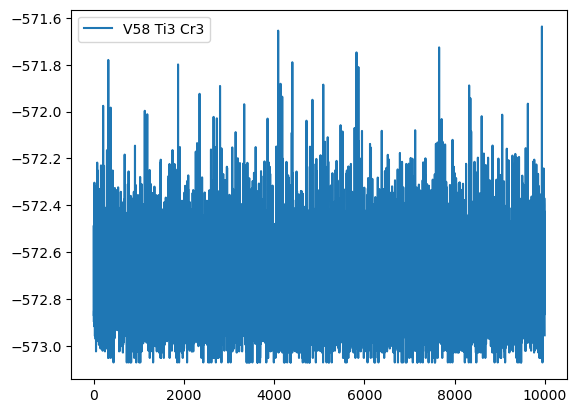

In [21]:
for i, expansion_path in enumerate(expansion_list):
    work = load_work(expansion_path)
    expansion = work['ClusterExpansion']
    # Create the ensemble
    # This specifies the size of the MC simulation domain.
    # this gives a 64 site unit cell
    sc_matrix = np.array([
        [4, 0, 0],
        [0, 4, 0],
        [0, 0, 4]
    ])
    # this convenience method will take care of creating the appropriate
    # processor for the given cluster expansion.
    #os.environ['OMP_NUM_THREADS'] = '4'
    ensemble = Ensemble.from_cluster_expansion(expansion, sc_matrix)
    ensemble.processor.num_threads_full = 5

    # In a real scenario you may want a much larger processor.size
    # An MC step is O(1) with the processor.size, meaning it runs at
    # the same speed regardless of the size. However, larger sizes
    # will need many more steps to reach equilibrium in an MC simulation.
    print(f'The supercell size for the processor is {ensemble.processor.size} prims.')
    print(f'The ensemble has a total of {ensemble.num_sites} sites.')
    print(f'The active sublattices are:')
    for sublattice in ensemble.sublattices:
        print(sublattice)


    # here we also set the temperature to our operating temperature, in V-Cr-Ti this should be around 900K 
    T_sample = 973.15
    sampler = Sampler.from_ensemble(ensemble, temperature=T_sample)
    print(f"Sampling information: {sampler.samples.metadata}")
    compositions = [sublattice.composition for sublattice in ensemble.sublattices]

    print(dir(sublattice))
    compositions = [sublattice.composition for sublattice in ensemble.sublattices]
    print(f'The compositions are {compositions}')
    try:
        # this will raise an error if the ensemble is not ordered
        init_occu = generate_random_ordered_occupancy(processor= ensemble.processor,
                                                    composition=compositions,
                                                    tol = 0.99,
                                                    rng=42)
    except:
        #raise ValueError('The ensemble is not ordered, please check the ensemble and try again.')
        print('The ensemble is not ordered, please check the ensemble and try again.')
        continue
    #init_occu = generate_random_ordered_occupancy(processor= ensemble.processor,
                                                #composition=compositions,
                                                #tol = 0.99,
                                                #rng=42)

    print(f"The disordered structure has composition: {ensemble.processor.structure.composition}")
    print(f"The initial occupancy has composition: {ensemble.processor.structure_from_occupancy(init_occu).composition}")

    print(f'The encoded occupancy is:\n{init_occu}')
    print(f'The initial occupancy is:\n {ensemble.processor.decode_occupancy(init_occu)}')

    # run 1M iterations
    # since this is the first run, the initial occupancy must be supplied
    sampler.run(
        1000000,
        initial_occupancies=init_occu,
        thin_by=100, # thin_by will save every 100th sample only
        progress=True
    ) # progress will show progress bar

    # Samples are saved in a sample container
    samples = sampler.samples

    print(f'Fraction of successful steps (efficiency) {sampler.efficiency()}')
    print(f'The last step energy is {samples.get_energies()[-1]} eV')
    print(f'The minimum energy in trajectory is {samples.get_minimum_energy()} eV')

    # You can get the minimum energy structure and current structure
    # by using the ensemble processor
    curr_s = ensemble.processor.structure_from_occupancy(samples.get_occupancies()[-1])
    min_s = ensemble.processor.structure_from_occupancy(samples.get_minimum_energy_occupancy())

    #from smol.moca.analysis.convergence import check_property_converged, determine_discard_number

    energies = samples.get_energies()
    # 100 as an initial guess for amount to discard
    #opt_discard = determine_discard_number(property_array=energies, init_discard=100, verbose=True)
    #converged = check_property_converged(energies[opt_discard:])
    #print(f'Is the energy converged after discarding the first {opt_discard} samples?', converged)
    print(energies)

    # let's plot the energy trajectories over time 

    import matplotlib.pyplot as plt
    runs = np.arange(len(energies))
    plt.plot(runs, energies,label=f'{ensemble.processor.structure_from_occupancy(init_occu).composition}')

    # Set 100 samples for burn-in, as determined in 5)
    discard = 100 # this is in terms of samples so it would be discard*thin_by steps
    print(f'A total of {len(samples)} samples taken.')
    print(f'A total of {len(samples.get_energies(discard=discard))} samples used for production.')
    print(f'The average energy is {samples.mean_energy(discard=discard)} eV')
    print(f'The energy variance is {samples.energy_variance(discard=discard)} eV^2')
    print(f'The sampling efficiency (acceptance rate) is approximately {samples.sampling_efficiency(discard=discard)}')


    #write these to cif files
    from pymatgen.io.cif import CifWriter
    structure_path = '../Visualization/Job_Structures/Pre_VASP/VCrTi_Fixed_64'

    initial_structure = samples.get_sampled_structures(indices=[0])[0]
    print(initial_structure)

    # ChANGE THE NAME 
    # get the composition of the structure
    composition = initial_structure.composition.reduced_formula

    # Find the start and end of the substring
    start = expansion_path.find('VCrTi_Fixed_64/') + len('VCrTi_Fixed_64/')
    end = expansion_path.find('_fin_work.mson')

    # Extract the substring
    substring = expansion_path[start:end]

    # write the initial structure to a CIF file
    cif = CifWriter(initial_structure)
    total_initial_path = os.path.join(structure_path, substring + '_initial.cif')
    cif.write_file(total_initial_path)

    # print the last structure 
    final_structure = samples.get_sampled_structures(indices=[-1])[0]
    print(final_structure)

    # write the final structure to a CIF file
    cif = CifWriter(final_structure)
    total_final_path = os.path.join(structure_path, substring + '_final.cif')
    cif.write_file(total_final_path)

    # instead of getting just the middle, pick 4 structures within the 25% and 75% quartile
    # Calculate the indices for the 25% and 75% quartiles
    # Calculate the indices for the 25% and 75% quartiles
    lower_quartile_index = len(samples) // 4
    upper_quartile_index = 3 * len(samples) // 4

    # Create a new list that contains only the elements between the 25% and 75% quartiles
    samp_range = np.arange(len(samples))

    # Check if samp_range is not empty
    if samp_range.size > 0:
        middle_samples = samp_range[lower_quartile_index:upper_quartile_index]
        # Randomly select 5 elements from the middle_samples list
        if len(middle_samples) >= 5:
            random_samples = random.sample(list(middle_samples), 5)
        else:
            print("Not enough samples for random selection.")
    else:
        print("samp_range is empty.")
    for samp in random_samples: 
        mid_structure = samples.get_sampled_structures(indices=[samp])[0]
        # write the middle structure to a CIF file
        cif = CifWriter(mid_structure)
        total_middle_path = os.path.join(structure_path, substring + '_middle_' + str(samp) + '.cif')
        cif.write_file(total_middle_path)
    
    #cif = CifWriter(middle_structure)
    #total_middle_path = os.path.join(structure_path, substring + '_middle.cif')
    #cif.write_file(total_middle_path)
    # save the Sample container with the same name 
    total_sample_path = os.path.join(structure_path, substring + '_samples.mson')

    save_work(total_sample_path,samples)

plt.legend()
plt.show()

In [7]:
# pick random structure within the middle quartiles of the runsteps from the samples and write to cif file
middle_quartile = len(samples)//4
print(samples)
# get teh structure from the middle quartile
middle_structure = samples.get_sampled_structures(indices=[middle_quartile])[0]
print(middle_structure)
# write the middle structure to a CIF file
cif = CifWriter(middle_structure)
total_middle_path = os.path.join(structure_path, substring + '_middle.cif')
cif.write_file(total_middle_path)

Full Formula (Ti24 V464 Cr24)
Reduced Formula: Ti3V58Cr3
abc   :  20.853892  20.853892  20.853892
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (512)
  #  SP        a      b      c
---  ----  -----  -----  -----
  0  V     0      0      0
  1  V     0      0      0.125
  2  V     0      0      0.25
  3  V     0      0      0.375
  4  V     0      0      0.5
  5  V     0      0      0.625
  6  V     0      0      0.75
  7  V     0      0      0.875
  8  V     0      0.125  0
  9  V     0      0.125  0.125
 10  V     0      0.125  0.25
 11  V     0      0.125  0.375
 12  V     0      0.125  0.5
 13  V     0      0.125  0.625
 14  V     0      0.125  0.75
 15  V     0      0.125  0.875
 16  V     0      0.25   0
 17  V     0      0.25   0.125
 18  V     0      0.25   0.25
 19  V     0      0.25   0.375
 20  V     0      0.25   0.5
 21  V     0      0.25   0.625
 22  V     0      0.25   0.75
 23  V     0      0.25   0.875
 24  V     0      0.375  0

In [25]:
import os
import numpy as np
from smol.io import load_work
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
import json

# Directory containing the .mson files
directory = '../Visualization/Job_Structures/Pre_VASP/VCrTi_fixed_64'

# Initialize an empty list to store the computed structure entries
computed_entries = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mson'):
        filepath = os.path.join(directory, filename)
        
        # Load the sample data from the .mson file
        samples = load_work(filepath)
        
        # Get the energies and structures
        energies = samples['SampleContainer'].get_energies()
        # Get the minimum energy and corresponding structure
        min_energy_index = np.argmin(energies)
        min_energy = energies[min_energy_index]

        min_structure = samples['SampleContainer'].get_sampled_structures(indices=[min_energy_index])[0]
        #min_structure = structures[min_energy_index]
                
        # Create a ComputedStructureEntry for the minimum energy structure
        min_entry = ComputedStructureEntry(structure=min_structure, energy=min_energy)
        
        # Append the entry to the list
        computed_entries.append(min_entry)

# Convert the list of entries to a JSON serializable format
entries_dict = [entry.as_dict() for entry in computed_entries]

# Save the list as a JSON file
output_filepath = '../Entries/post_mcmc_vcrti_entries.json'
with open(output_filepath, 'w') as f:
    json.dump(entries_dict, f)

print(f"Saved computed entries to {output_filepath}")


Saved computed entries to ../Entries/post_mcmc_vcrti_entries.json
